In [102]:
import numpy as np
import pandas as pd
import seaborn as sns
import os, glob, math
from itertools import cycle
from scipy import interp
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA
from sklearn.feature_selection import VarianceThreshold

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import precision_recall_curve, confusion_matrix, accuracy_score, roc_auc_score, precision_recall_fscore_support, average_precision_score, recall_score, f1_score, precision_score, PrecisionRecallDisplay

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Activation, Conv1D
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
np.random.seed(1234)

tf.device("device:GPU:0")

# Data loading

In [48]:
with open('trainset_python/python/class_names.txt') as f:
    classes = f.readlines()

for i,c in enumerate(classes):
    classes[i] = c.strip()

In [49]:
with open('trainset_python/python/feature_names.txt') as f:
    features = f.readlines()

for i,feature in enumerate(features):
    features[i] = feature.strip()

In [61]:
#all files in one dataframe
idx = pd.Series([i for i in range(100)])

rootdir = os. getcwd()
files_stand_train = pd.DataFrame([])
labels_train_all = pd.DataFrame([])
files_stand_test = pd.DataFrame([])
labels_test_all = pd.DataFrame([])


files_stand_train_cnn = []
labels_train_all_cnn = []
files_stand_test_cnn = []
labels_test_all_cnn = []

    
for i,f in enumerate(glob.glob(rootdir + '/trainset_python/**/*.npy', recursive=True)):
    if (i % 2) == 0:
        label = pd.DataFrame(np.load(f))
        
        if (i<320 or i>399) and (i<720 or i>799) and (i<1120 or i>1199) and (i<1520 or i>1599) and (i<1920 or i>1999) and (i<2320 or i>2399):
            for j, col in enumerate(label.columns):
                if j == 0:
                    label = label.rename(columns={label.columns[0]: "overall_class_vote"})
                else:
                    label = label.rename(columns={col: "class_vote_" + str(j)})
            if labels_train_all.empty:
                labels_train_all = label
                labels_train_all_cnn.append(label)
            else:
                idx = idx + (j*100)
                label.index = idx
                labels_train_all = pd.concat([labels_train_all,label])
                labels_train_all_cnn.append(label)
        else:
            for j, col in enumerate(label.columns):
                if j == 0:
                    label = label.rename(columns={label.columns[0]: "overall_class_vote"})
                else:
                    label = label.rename(columns={col: "class_vote_" + str(j)})
            if labels_test_all.empty:
                labels_test_all = label
                labels_test_all_cnn.append(label)
            else:
                idx = idx + (j*100)
                label.index = idx
                labels_test_all = pd.concat([labels_test_all,label])
                labels_test_all_cnn.append(label)
    else:
        file_stand = pd.DataFrame(StandardScaler().fit_transform(np.load(f)), columns = features)

        if (i<320 or i>399) and (i<720 or i>799) and (i<1120 or i>1199) and (i<1520 or i>1599) and (i<1920 or i>1999) and (i<2320 or i>2399):
            if files_stand_train.empty:
                files_stand_train = file_stand
                files_stand_train_cnn.append(file_stand)
            else:
                idx = idx + (i*100)
                file_stand.index = idx
                files_stand_train = pd.concat([files_stand_train,file_stand])
                files_stand_train_cnn.append(file_stand)
        else:
            if files_stand_test.empty:
                files_stand_test = file_stand
                files_stand_test_cnn.append(file_stand)
            else:
                idx = idx + (i*100)
                file_stand.index = idx
                files_stand_test = pd.concat([files_stand_test,file_stand])
                files_stand_test_cnn.append(file_stand)

labels_train_all.index = pd.Series([i for i in range(len(labels_train_all))])
files_stand_train.index = pd.Series([i for i in range(len(files_stand_train))])
labels_test_all.index = pd.Series([i for i in range(len(labels_test_all))])
files_stand_test.index = pd.Series([i for i in range(len(files_stand_test))])

# Drop samples with disagreement

In [64]:
def sample_dataframe_by_threshold(file_stand, lables):
    dropped_indices = []
    nr_annotators = [0, 0, 0, 0, 0]

    invalid_samples = 0
    for i, sample in enumerate(file_stand.copy().to_numpy()[:, -7:]):
        sample_has_nans = 0
        sample_nan_idx = []
        for l, val in enumerate(sample):
            if math.isnan(val):
                sample_nan_idx.append(l)
                sample_has_nans += 1
        # remove nans from sample
        sample = np.delete(sample, sample_nan_idx)
        # print(sample)
        classes_vote = [np.count_nonzero((sample == 1) | (sample == 1.0)), np.count_nonzero((sample == 2) | (sample == 2.0)), np.count_nonzero((sample == 3) | (sample == 3.0)),
                        np.count_nonzero((sample == 4) | (sample == 4.0)), np.count_nonzero((sample == 5) | (sample == 5.0)), np.count_nonzero((sample == 6) | (sample == 6.0))]
        # accept fragments with no votes and votes above current threshold
        if np.max(classes_vote) / len(sample) > 0:
            #accept all samples for 3 annotators
            """if len(sample) == 3 and np.max(classes_vote) / len(sample) < 3/3:
                invalid_samples += 1
                inner_list_dropped_indices.append(i)
                nr_annotators[0] += 1"""
            if len(sample) == 4 and np.max(classes_vote) / len(sample) < 3/4:
                invalid_samples += 1
                dropped_indices.append(i)
                nr_annotators[1] += 1
            elif len(sample) == 5 and np.max(classes_vote) / len(sample) < 3/5:
                invalid_samples += 1
                dropped_indices.append(i)
                nr_annotators[2] += 1
            elif len(sample) == 6 and np.max(classes_vote) / len(sample) < 4/6:
                invalid_samples += 1
                dropped_indices.append(i)
                nr_annotators[3] += 1
            elif len(sample) == 7 and np.max(classes_vote) / len(sample) < 5/7:
                invalid_samples += 1
                dropped_indices.append(i)
                nr_annotators[4] += 1
    # drop the samples with < threshold than selected
    sampled_dataframe = file_stand.drop(dropped_indices).reset_index()
    lables_agree = lables.drop(dropped_indices)
    # drop vote columns and index_column
    sampled_dataframe = sampled_dataframe.iloc[:, 1:-8]
    #print(nr_annotators)
    return sampled_dataframe, lables_agree

In [65]:
data_stand_train = pd.DataFrame(pd.concat((files_stand_train, labels_train_all), axis=1))
data_stand_test = pd.DataFrame(pd.concat((files_stand_test, labels_test_all), axis=1))

In [66]:
files_train, labels_train = sample_dataframe_by_threshold(data_stand_train, labels_train_all)
files_test, labels_test = sample_dataframe_by_threshold(data_stand_test, labels_test_all)

labels_train.to_csv('data_temp/labels_train', index=False)
labels_test.to_csv('data_temp/labels_test', index=False)

# Drop correlated features

In [68]:
# drop highly correlated features
corr_train = files_train.corr()

# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything other feature

def correlation(corr_matrix, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

corr_features_train = correlation(corr_train, 0.9)
files_train = files_train.drop(corr_features_train,axis=1)
files_test = files_test.drop(corr_features_train,axis=1)

# Select features

In [70]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

fifty_cols = SelectKBest(mutual_info_classif, k=50)
fifty_cols.fit(files_train, labels_train['overall_class_vote'])
selected_features_50 = files_train.columns[fifty_cols.get_support()]

In [72]:
pd.DataFrame(selected_features_50)

,0
0,zcr_mean
1,yin_5
2,yin_6
3,yin_7
4,yin_9
5,raw_melspect_mean_4
6,raw_melspect_mean_5
7,raw_melspect_mean_6
8,raw_melspect_mean_7
9,raw_melspect_mean_8


In [73]:
files_train_50 = pd.DataFrame()
files_test_50 = pd.DataFrame()

for idx in selected_features_50:
    files_train_50[idx] = files_train[idx]
    files_test_50[idx] = files_test[idx]

files_train_50.to_csv('data_temp/files_train_50', index=False)
files_test_50.to_csv('data_temp/files_test_50', index=False)

In [77]:
train_files_cnn = []
test_files_cnn = []

for rec in files_stand_train_cnn:
    rec_app = pd.DataFrame() 
    for idx in selected_features_50:
        rec_app[idx] = rec[idx]
    train_files_cnn.append(rec_app)
    
for rec in files_stand_test_cnn:
    rec_app = pd.DataFrame() 
    for idx in selected_features_50:
        rec_app[idx] = rec[idx]
    test_files_cnn.append(rec_app)

# Reload Data 

In [18]:
labels_test = pd.read_csv('data_temp/labels_test')
labels_train = pd.read_csv('data_temp/labels_train')
files_test_50 = pd.read_csv('data_temp/files_test_50')
files_train_50 = pd.read_csv('data_temp/files_train_50')

y_test = labels_test['overall_class_vote']
y_train = labels_train['overall_class_vote']

data_test_50 = []
for i in range(10):
    data_test_50.append(pd.read_csv('data_test_temp/file_train_50_0' + str(i)))
for i in range(10,16):
    data_test_50.append(pd.read_csv('data_test_temp/file_train_50_' + str(i)))

# Evaluation

In [14]:
def get_savings(predictions, y_true, detail=0):
    '''
    detail: 0 -> show all information
            1 -> show conf_matrix, heatmap, savings
            2 -> show heatmap and savings
    '''
    
    f1 = f1_score(y_true, predictions, average="macro")
    precision = precision_score(y_true, predictions, average="macro")
    recall = recall_score(y_true, predictions, average="macro")
    conf_mat = confusion_matrix(y_true, predictions)

    if detail == 1 or detail == 0:
        if detail == 0:
            print('F1 =',f1)
            print('Precision =',precision)
            print('Recall =', recall)
        print('confusion matrix\n', conf_mat)
    
    cost_matrix = [[0.05, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2],
                   [-0.25, 1, -0.3, -0.1, -0.1, -0.1, -0.1],
                   [-0.02, -0.1, 1, -0.1, -0.1, -0.1, -0.1],
                   [-0.25, -0.1, -0.3, 1, -0.1, -0.1, -0.1],
                   [-0.25, -0.1, -0.3, -0.1, 1, -0.1, -0.1],
                   [-0.25, -0.1, -0.3, -0.1, -0.1, 1, -0.1],
                   [-0.25, -0.1, -0.3, -0.1, -0.1, -0.1, 1]]

    savings = np.multiply(cost_matrix, conf_mat)
    max_savings = np.sum(np.multiply(cost_matrix,  confusion_matrix(y_true, y_true)))
    
    # set [0][0] to 2nd highest value to get better heatmap and plot the heatmap
    heat = np.copy(conf_mat)
    ind = np.argpartition(heat.max(1), -2)[-2:][0]
    heat[0,0] = heat.max(1)[ind]
    sns.heatmap(heat,cmap=plt.cm.CMRmap_r)
    plt.show()
    
    print('max savings: ', max_savings)
    print('savings: ', np.sum(savings), '\n')

# Postprocessing

In [16]:
def postprocess(preds):
    preds_post = np.copy(preds)
    i_max = len(preds_post)
    for i,c in enumerate(preds_post):
        
        # what to do with first prediction?
        if i == 0:
            pass
        
        # 
        if i > 0 and i < i_max-1:
            # CHANGE!!!
            if preds_post[i-1] == 2 and i > 1 and i < i_max-2:
                if preds_post[i-2] == preds_post[i+2]:
                    preds_post[i] = preds_post[i-1]
        
            # case yny flip to yyy, important to do before nyn to nnn
            if preds_post[i-1] == preds_post[i+1] and preds_post[i-1] != 0:
                preds_post[i] = preds_post[i-1]
                       
            # case nnynn flip to nnnnn if class not grswoo (because they have short calls)
            if  i > 1 and i < i_max-2:
                if preds_post[i-2] == preds_post[i-1] == preds_post[i+1] == preds_post[i+2] and preds_post[i] != 5:
                    preds_post[i] = preds_post[i-1]

        
        '''
        if i > 1 and i < len(preds_post)-2:
            if preds_post[i-2] == preds_post[i-1] == preds_post[i+1] == preds_post[i+2]:
                preds_post[i] = preds_post[i-1]
        '''
    return preds_post

## Vizualization

In [17]:
def post_process_viz(preds, preds_post, y_test, start=0, stop=150):
    
    fix,axs = plt.subplots(3,1,figsize=(20,15))
    for i,c in enumerate(preds[start:stop]):
        axs[0].bar(i,c,color='b',width=1)
        axs[0].set_title('predictions without post processing')
    for i,c in enumerate(preds_post[start:stop]):
        axs[1].bar(i,c,color='b',width=1)
        axs[1].set_title('predictions after post processing')
    for i,c in enumerate(y_test[start:stop]):
        axs[2].bar(i,c,color='b',width=1)
        axs[2].set_title('True calls')
    plt.show()

# NN

In [6]:
# Aufbau des Modells mit Keras
bird_model = Sequential()
bird_model.add(Dense(30,input_shape=(50,),activation="relu"))
bird_model.add(Dense(25,activation="relu"))
bird_model.add(Dense(15,activation="relu"))
bird_model.add(Dense(7,activation="softmax"))

In [7]:
sgd = SGD(learning_rate=0.001)

Epoch 1/250
7164/7164 [==============================] - 32s 4ms/step - loss: 1.0364 - accuracy: 0.6735 - mean_absolute_error: 0.1328 - val_loss: 1.1066 - val_accuracy: 0.7364 - val_mean_absolute_error: 0.1170
Epoch 2/250
7164/7164 [==============================] - 28s 4ms/step - loss: 0.9074 - accuracy: 0.7055 - mean_absolute_error: 0.1148 - val_loss: 1.0649 - val_accuracy: 0.7325 - val_mean_absolute_error: 0.1110
Epoch 3/250
7164/7164 [==============================] - 30s 4ms/step - loss: 0.8651 - accuracy: 0.7159 - mean_absolute_error: 0.1110 - val_loss: 1.0108 - val_accuracy: 0.7339 - val_mean_absolute_error: 0.1063
Epoch 4/250
7164/7164 [==============================] - 29s 4ms/step - loss: 0.8272 - accuracy: 0.7286 - mean_absolute_error: 0.1076 - val_loss: 0.9692 - val_accuracy: 0.7465 - val_mean_absolute_error: 0.1042
Epoch 5/250
7164/7164 [==============================] - 27s 4ms/step - loss: 0.7920 - accuracy: 0.7437 - mean_absolute_error: 0.1042 - val_loss: 0.8881 - val_a

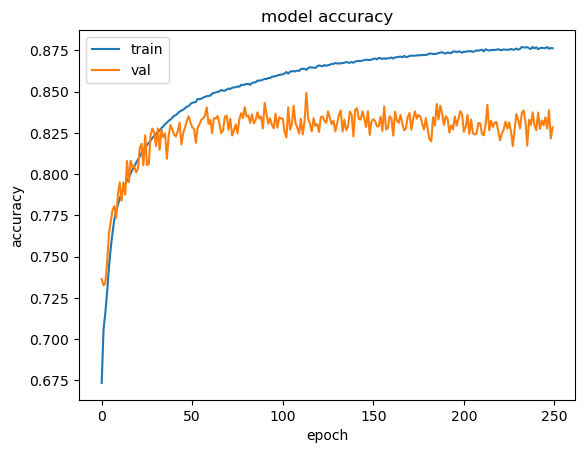

In [12]:
labels_train_cat = to_categorical(labels_train['overall_class_vote'])

bird_model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["accuracy",tf.keras.metrics.mae])
history = bird_model.fit(x=files_train_50, y=labels_train_cat,validation_split = 0.1, batch_size=10, epochs=250, verbose=1)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

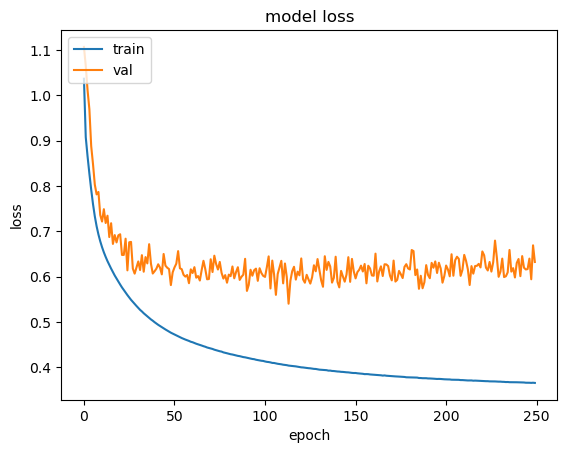

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Post-process

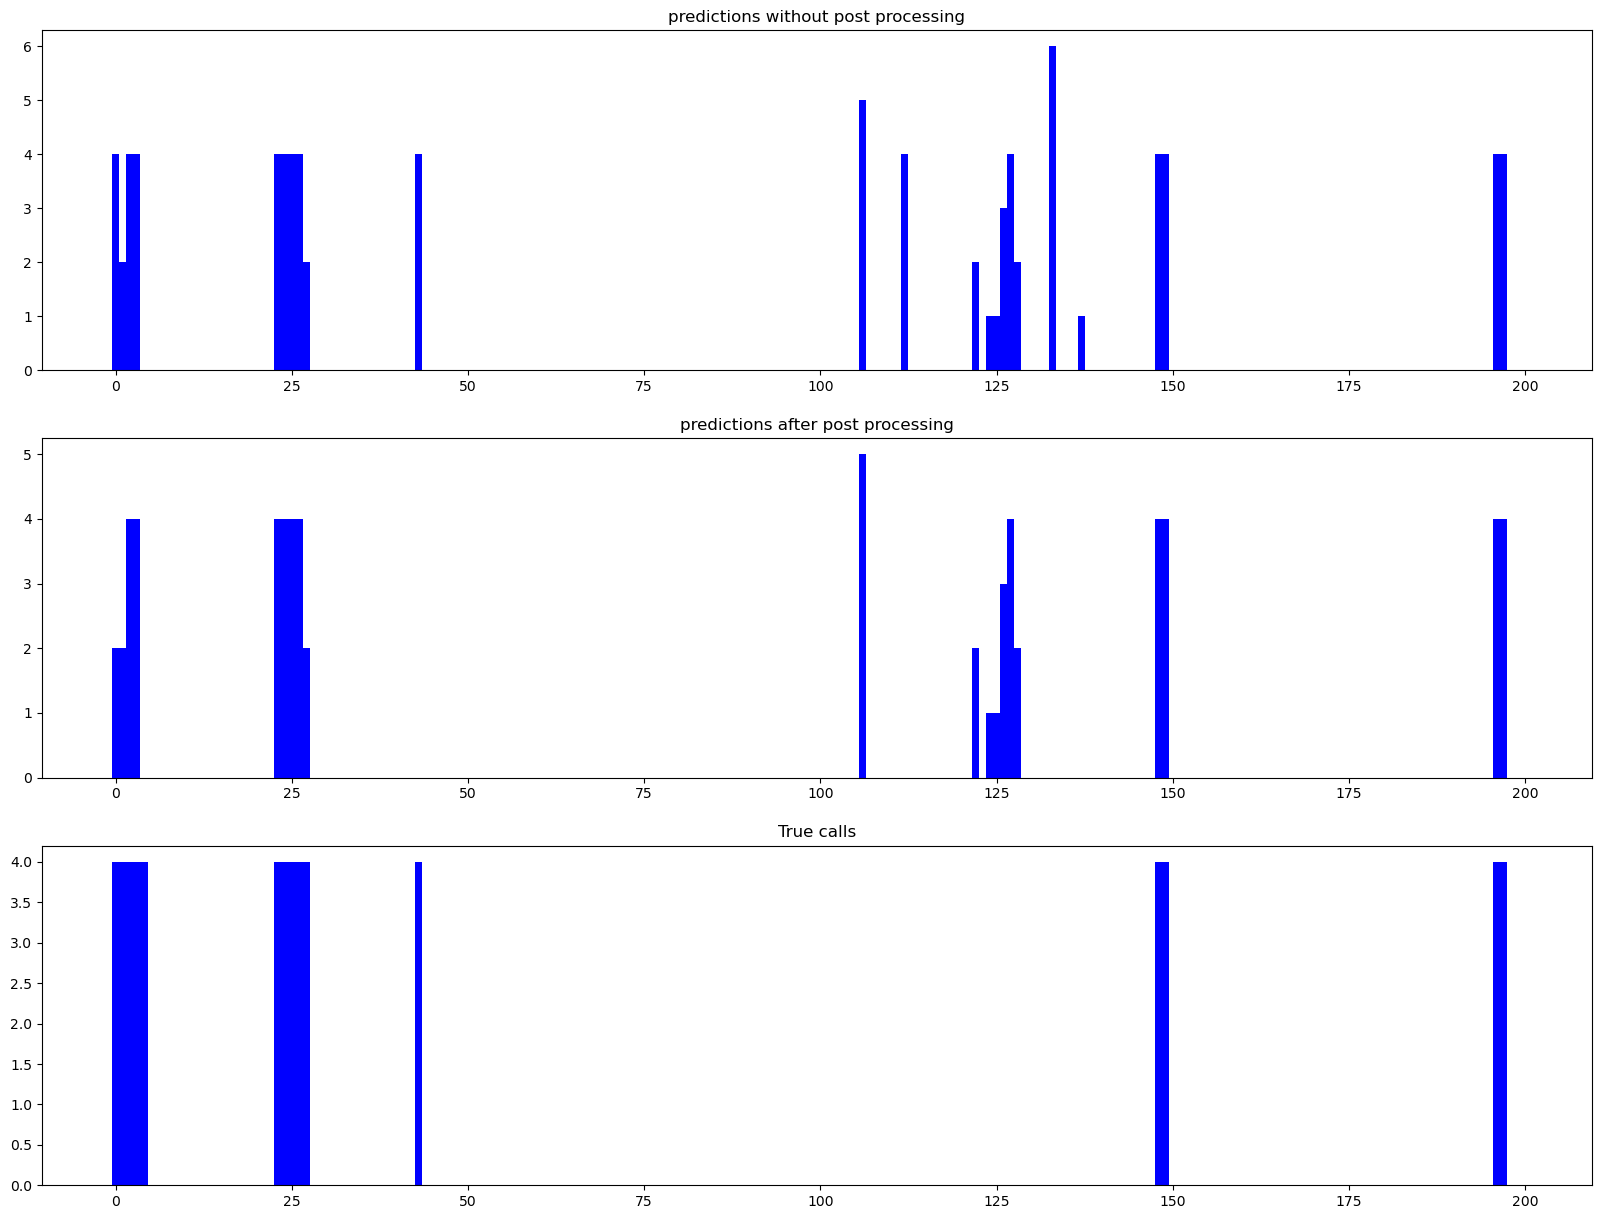

In [38]:
preds = bird_model.predict(files_test_50)
preds = preds.argmax(axis=1)
preds_post = postprocess(preds)

post_process_viz(preds, preds_post, y_test, start=13140, stop=13340)

## Evaluate

confusion matrix
 [[13705   127   114    71    13   194    34]
 [  187   659    16    51     3    47     3]
 [  360    11  1016   241    15     9     1]
 [  145    44   186   787    13    16     5]
 [   62     7    52    16   223    26    12]
 [  263     7     4     6     1   675    61]
 [  113    38     4    18    12   113   368]]


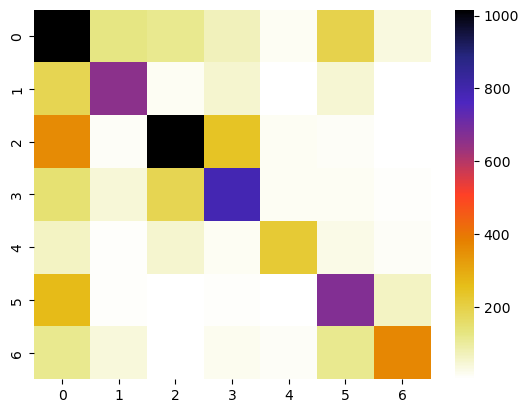

max savings:  6608.9
savings:  3946.75 

confusion matrix
 [[13731   100    96    53     8   240    30]
 [  145   731    14    31     1    42     2]
 [  267     6  1204   166     4     5     1]
 [   95    32   193   844    10    17     5]
 [   72     8    57    14   211    25    11]
 [  216     6     4     3     1   739    48]
 [  107    38     3    16     9   114   379]]


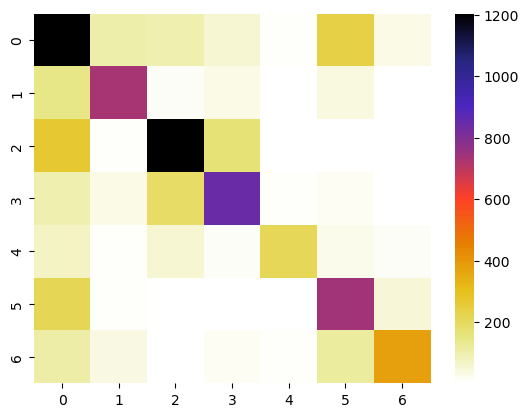

max savings:  6608.9
savings:  4382.26 



In [39]:
get_savings(preds,y_test,detail=1)
get_savings(preds_post,y_test,detail=1)

# CNN

## Data manipulation to get valid input

### get one-hot labels

In [249]:
test_labels_cnn = []
train_labels_cnn = []

y_test = []

for file in labels_train_all_cnn:
    label = to_categorical(file['overall_class_vote'], num_classes=7)
    train_labels_cnn.append(label)
    
for file in labels_test_all_cnn:
    label = to_categorical(file['overall_class_vote'], num_classes=7)
    test_labels_cnn.append(label)
    y_test.append(file['overall_class_vote'])

(100, 7)

### get padded data

In [259]:
def padding(array, xx, yy=50):
    """
    :param array: numpy array
    :param xx: desired height
    :param yy: desirex width
    :return: padded array
    """
    h = array.shape[0]
    w = array.shape[1]
    a = max((xx - h) // 2,0)
    aa = max(0,xx - a - h)
    b = max(0,(yy - w) // 2)
    bb = max(yy - b - w,0)
    return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant')

def padding_1d(array, xx):
    """
    :param array: numpy array
    :param xx: desired height
    :param yy: desirex width
    :return: padded array
    """
    h = array.shape[0]
    a = max((xx - h) // 2,0)
    aa = max(0,xx - a - h)
    return np.pad(array, pad_width=((a, aa)), mode='constant')

In [260]:
test_files_cnn_pad = []
train_files_cnn_pad = []
train_labels_cnn_pad = []
test_labels_cnn_pad = []

y_test_pad = []

for file in test_files_cnn:
    pad = padding(file, 3000, 50)
    test_files_cnn_pad.append(pad)
    
for file in train_files_cnn:
    pad = padding(file, 3000, 50)
    train_files_cnn_pad.append(pad)
    
for file in train_labels_cnn:
    pad = padding(file, 3000, 7)
    train_labels_cnn_pad.append(pad)
    
for file in test_labels_cnn:
    pad = padding(file, 3000, 7)
    test_labels_cnn_pad.append(pad)
    
for file in y_test:
    pad = padding_1d(file, 3000)
    y_test_pad.append(pad)

In [240]:
print(len(train_files_cnn_pad))
print(train_files_cnn_pad[0].shape)
print(test_files_cnn_pad[0].shape)
print(train_labels_cnn_pad[0].shape)

960
(3000, 50)
(3000, 50)
(3000, 7)


In [233]:
X_train = np.array(train_files_cnn_pad)
y_train = np.array(train_labels_cnn_pad)
X_test = np.array(test_files_cnn_pad)
y_test = np.array(test_labels_cnn_pad)

### CNN-Model

In [232]:
keras.backend.clear_session()

In [234]:
# Aufbau des Modells mit Keras
input_shape=(4,3000,50)
bird_model_2 = Sequential()
bird_model_2.add(Conv1D(30, 5, activation='relu',padding='causal', input_shape=input_shape[1:]))
#bird_model_1.add(layers.MaxPooling1D((2, 2)))
#bird_model_1.add(layers.Dropout(0.2))
bird_model_2.add(Dense(7, activation='softmax'))
bird_model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 3000, 30)          7530      
_________________________________________________________________
dense (Dense)                (None, 3000, 7)           217       
Total params: 7,747
Trainable params: 7,747
Non-trainable params: 0
_________________________________________________________________


In [235]:
adam = Adam(learning_rate=0.001)

### training

Epoch 1/20
87/87 [==============================] - 1s 8ms/step - loss: 0.0360 - accuracy: 0.9887 - mean_absolute_error: 0.1428 - val_loss: 0.0295 - val_accuracy: 0.9916 - val_mean_absolute_error: 0.1418
Epoch 2/20
87/87 [==============================] - 1s 6ms/step - loss: 0.0248 - accuracy: 0.9926 - mean_absolute_error: 0.1414 - val_loss: 0.0274 - val_accuracy: 0.9923 - val_mean_absolute_error: 0.1414
Epoch 3/20
87/87 [==============================] - 1s 7ms/step - loss: 0.0223 - accuracy: 0.9932 - mean_absolute_error: 0.1412 - val_loss: 0.0265 - val_accuracy: 0.9926 - val_mean_absolute_error: 0.1412
Epoch 4/20
87/87 [==============================] - 1s 6ms/step - loss: 0.0212 - accuracy: 0.9935 - mean_absolute_error: 0.1410 - val_loss: 0.0282 - val_accuracy: 0.9924 - val_mean_absolute_error: 0.1413
Epoch 5/20
87/87 [==============================] - 1s 7ms/step - loss: 0.0209 - accuracy: 0.9936 - mean_absolute_error: 0.1410 - val_loss: 0.0283 - val_accuracy: 0.9926 - val_mean_abs

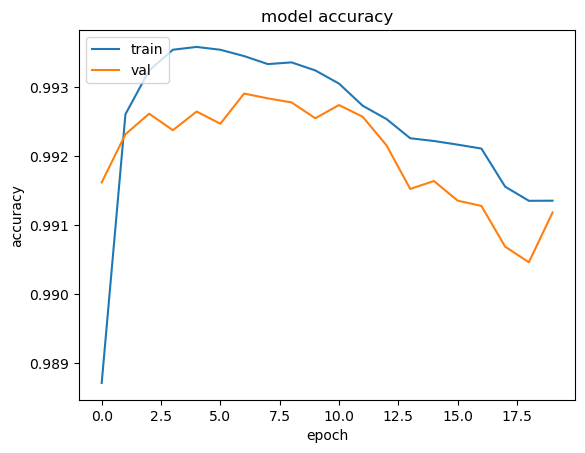

In [236]:
bird_model_2.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy",tf.keras.metrics.mae])
history = bird_model_2.fit(x=X_train, y=y_train,validation_split = 0.1, batch_size=10, epochs=20, verbose=1)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

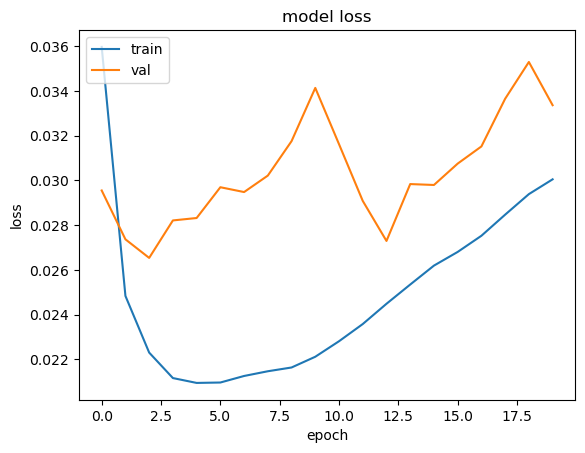

In [237]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Post-process

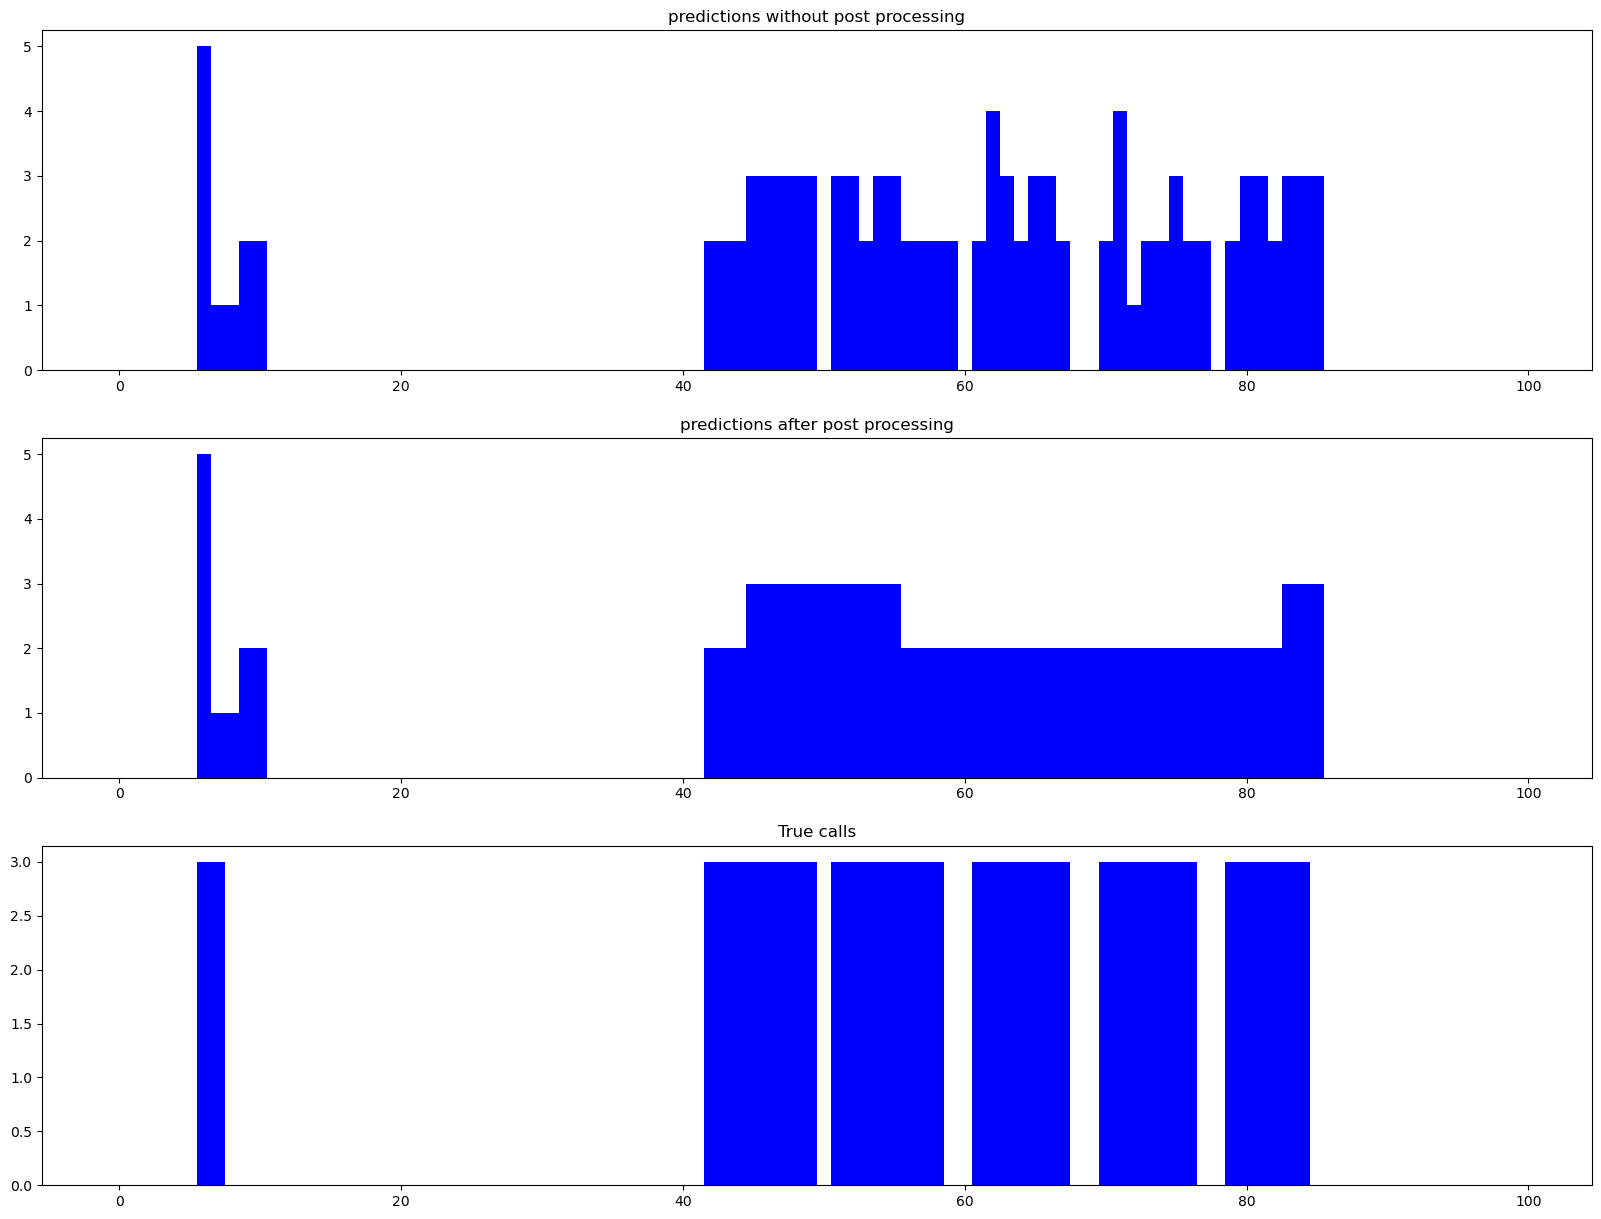

In [268]:
preds = bird_model_2.predict(X_test)
preds_1d = []
preds_post = []

for p in preds:
    preds_1d.append(p.argmax(axis=1))
    preds_post.append(postprocess(p.argmax(axis=1)))
    
post_process_viz(preds_1d[100], preds_post[100], y_test_pad[100], start=1450, stop=1550)

## Evaluate

confusion matrix
 [[13655   135   134   115    18   170    31]
 [  182   647    12    79     6    32     8]
 [  357    17   954   282    29    13     1]
 [  139    40   172   812    14    16     3]
 [   51     5    45    23   246    23     5]
 [  311    16    15    10     8   615    42]
 [  104    30     2    25    15   116   374]]


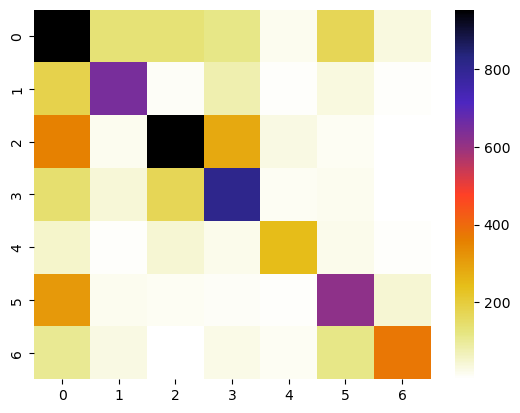

max savings:  6608.9
savings:  3846.66 

confusion matrix
 [[13687   125   119    88     8   208    23]
 [  135   715     6    71     5    27     7]
 [  253    14  1161   208     8     9     0]
 [   98    33   180   856    13    14     2]
 [   62     4    45    21   237    25     4]
 [  267    14    10     7     9   675    35]
 [   99    27     2    22    15   123   378]]


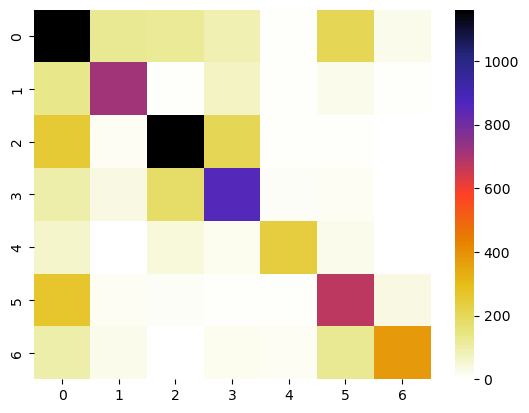

max savings:  6608.9
savings:  4277.240000000002 



In [46]:
get_savings(preds,y_test,detail=1)
get_savings(preds_post,y_test,detail=1)